In [11]:
import numpy as np
import uncertainties as unc
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as op
from scipy.linalg import sqrtm
from tqdm import tqdm

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib notebook

# Linear inversion

In [2]:
M1 = 0.5*np.array([[2, -1+1j, -1-1j,1],
                   [-1-1j,0,1j,0],
                   [-1+1j,-1j,0,0],
                   [1,0,0,0]])

M2 = 0.5*np.array([[0,-1+1j,0,1],
                   [-1-1j,2,1j,-1-1j],
                   [0,-1j,0,0],
                   [1,-1+1j,0,0]])

M3 = 0.5*np.array([[0,0,0,1],
                   [0,0,1j,-1-1j],
                   [0,-1j,0,-1+1j],
                   [1,-1+1j,-1-1j,2]])

M4 = 0.5*np.array([[0,0,-1-1j,1],
                   [0,0,1j,0],
                   [-1+1j,-1j,2,-1+1j],
                   [1,0,-1-1j,0]])

M5 = 0.5*np.array([[0,0,2j,-1-1j],
                   [0,0,1-1j,0],
                   [-2j,1+1j,0,0],
                   [-1+1j,0,0,0]])

M6 = 0.5*np.array([[0,0,0,-1-1j],
                   [0,0,1-1j,2j],
                   [0,1+1j,0,0],
                   [-1+1j,-2j,0,0]])

M7 = 0.5*np.array([[0,0,0,-1-1j],
                   [0,0,-1+1j,2],
                   [0,-1-1j,0,0],
                   [-1+1j,2,0,0]])

M8 = 0.5*np.array([[0,0,2,-1-1j],
                   [0,0,-1+1j,0],
                   [2,-1-1j,0,0],
                   [-1+1j,0,0,0]])

M9 = 1.0*np.array([[0,0,0,1j],
                   [0,0,-1j,0],
                   [0,1j,0,0],
                   [-1j,0,0,0]])

M10 = 1.0*np.array([[0,0,0,1],
                    [0,0,1,0],
                    [0,1,0,0],
                    [1,0,0,0]])

M11 = 1.0*np.array([[0,0,0,1j],
                    [0,0,1j,0],
                    [0,-1j,0,0],
                    [-1j,0,0,0]])

M12 = 0.5*np.array([[0,2,0,-1-1j],
                    [2,0,-1-1j,0],
                    [0,-1+1j,0,0],
                    [-1+1j,0,0,0]])

M13 = 0.5*np.array([[0,0,0,-1-1j],
                    [0,0,-1-1j,0],
                    [0,-1+1j,0,2],
                    [-1+1j,0,2,0]])

M14 = 0.5*np.array([[0,0,0,-1+1j],
                    [0,0,1-1j,0],
                    [0,1+1j,0,-2j],
                    [-1-1j,0,2j,0]])

M15 = 0.5*np.array([[0,-2j,0,-1+1j],
                    [2j,0,1-1j,0],
                    [0,1+1j,0,0],
                    [-1-1j,0,0,0]])

M16 = 1.0*np.array([[0,0,0,1],
                    [0,0,-1,0],
                    [0,-1,0,0],
                    [1,0,0,0]])

Ms = [M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16]

In [3]:
def rho_LI(ns,Mss,dtype=complex):
    N = np.sum(ns[:4])
    rho = np.zeros((4,4),dtype=dtype)
    for i,n in enumerate(ns):
        rho += (1.*n/N)*Mss[i]
    return rho

def hermitian_deviation(M):
    return M - np.conj(np.transpose(M))

@np.vectorize
def poissonize(x):
    return unc.ufloat(x,np.sqrt(x))

def plot_rho(rho):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    thickness = 0.2

    x_pos, y_pos = np.meshgrid([1,2,3,4],[1,2,3,4])
    x_pos = x_pos.ravel() - thickness/2
    y_pos = y_pos.ravel() # - thickness/2

    labels = ['HH', 'HV', 'VH', 'VV']

    z_pos = 0
    dz = np.real(rho).ravel()

    colors = ['blue' if z > 0 else 'purple' for z in dz]

    ax.bar3d(x_pos,y_pos,z_pos,dx=thickness,dy=thickness,dz=dz,color=colors)

    x_pos += thickness
    # y_pos += thickness

    dz = np.imag(rho).ravel()

    colors = ['orange' if z > 0 else 'red' for z in dz]

    ax.bar3d(x_pos,y_pos,z_pos,dx=thickness,dy=thickness,dz=dz,color=colors)


    plt.xticks(ticks=[1,2,3,4],labels=labels)
    plt.yticks(ticks=[1,2,3,4],labels=labels)

    ax.set_zlim(-0.1,0.6)
    
    return fig,ax

def round_err(v,s):
    o = int(np.floor(np.log10(s)))
#     print(o)
    sig = 10**o*int(s/10**o + 0.5)
    val = int(v/10**o + np.sign(v)*0.5)*10**o
    return val,sig

In [4]:
ns_trial = [34749,324,35805,444,
            16324,17521,13441,16901,
            17932,32028,15132,17238,
            13171,17170,16722,33586]
N = np.sum(ns_trial[:4])

rho_target = np.array([[0.4872,-0.0042+0.0114j,-0.0098-0.0178j,0.5192+0.0380j],
                       [-0.0042-0.0114j,0.0045,0.0271-0.0146j,-0.0648-0.0076j],
                       [-0.0098+0.0178j,0.0271+0.0146j,0.0062,-0.0695+0.0134j],
                       [0.5192-0.0380j,-0.0648+0.0076j,-0.0695-0.0134j,0.5020]])

rho_trial = rho_LI(ns_trial,Ms)

In [26]:
for i,M in enumerate(Ms):
    print(i+1,np.sum(np.abs(hermitian_deviation(M))))

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0


In [5]:
(rho_target - rho_trial)

array([[-1.29216791e-05+0.00000000e+00j, -1.47556154e-05-2.00386977e-05j,
        -4.84506884e-05+4.16196966e-05j, -8.65931970e-06-2.47329015e-05j],
       [-1.47556154e-05+2.00386977e-05j, -4.27778245e-05+0.00000000e+00j,
        -3.04786742e-05-4.22310087e-06j,  2.57199742e-05+2.03695914e-05j],
       [-4.84506884e-05-4.16196966e-05j, -3.04786742e-05+4.22310087e-06j,
        -2.52881299e-05+0.00000000e+00j, -4.73766860e-05+1.70326127e-05j],
       [-8.65931970e-06+2.47329015e-05j,  2.57199742e-05-2.03695914e-05j,
        -4.73766860e-05-1.70326127e-05j, -1.90123665e-05+0.00000000e+00j]])

### Actual computation

In [4]:
df = pd.read_csv('data/Quantum_Tomography/tomo_synth.csv')
df

,phi plus,phi minus,decoherence
0,2350,2275,2275
1,86,210,210
2,2050,2038,2038
3,110,161,161
4,1150,1150,1150
5,1250,1250,1250
6,1100,1100,1100
7,1188,1188,1188
8,1000,1000,1000
9,2150,279,1700


In [15]:
# print data
for i in range(len(df)):
    s = '%d ' %(i+1)
    for n in df.loc[i]:
        s += '& $%d \\pm %d$ ' % round_err(n,np.sqrt(n))
    s += '\\\\'
    print(s)

1 & $2350 \pm 50$ & $2280 \pm 50$ & $2280 \pm 50$ \\
2 & $86 \pm 9$ & $210 \pm 10$ & $210 \pm 10$ \\
3 & $2050 \pm 50$ & $2040 \pm 50$ & $2040 \pm 50$ \\
4 & $110 \pm 10$ & $160 \pm 10$ & $160 \pm 10$ \\
5 & $1150 \pm 30$ & $1150 \pm 30$ & $1150 \pm 30$ \\
6 & $1250 \pm 40$ & $1250 \pm 40$ & $1250 \pm 40$ \\
7 & $1100 \pm 30$ & $1100 \pm 30$ & $1100 \pm 30$ \\
8 & $1190 \pm 30$ & $1190 \pm 30$ & $1190 \pm 30$ \\
9 & $1000 \pm 30$ & $1000 \pm 30$ & $1000 \pm 30$ \\
10 & $2150 \pm 50$ & $280 \pm 20$ & $1700 \pm 40$ \\
11 & $850 \pm 30$ & $850 \pm 30$ & $850 \pm 30$ \\
12 & $1250 \pm 40$ & $1250 \pm 40$ & $1250 \pm 40$ \\
13 & $1200 \pm 30$ & $1200 \pm 30$ & $1200 \pm 30$ \\
14 & $1080 \pm 30$ & $1080 \pm 30$ & $1080 \pm 30$ \\
15 & $1260 \pm 40$ & $1260 \pm 40$ & $1260 \pm 40$ \\
16 & $2100 \pm 50$ & $140 \pm 10$ & $1690 \pm 40$ \\


<IPython.core.display.Javascript object>


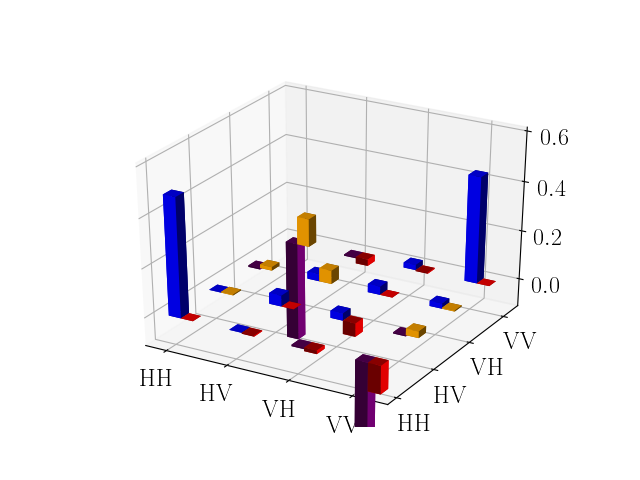

In [14]:
%matplotlib notebook

state = 'phi plus'
name = 'tomo_li_1'

state = 'phi minus'
name = 'tomo_li_2'

# state = 'decoherence'
# name = 'tomo_li_3'

ns = np.array(df[state])

ns_err = poissonize(ns)

rho = rho_LI(ns,Ms)

rho_err_real = rho_LI(ns_err,[np.real(M) for M in Ms],dtype=type(unc.ufloat(0,1)))
rho_err_imag = rho_LI(ns_err,[np.imag(M) for M in Ms],dtype=type(unc.ufloat(0,1)))


fig,ax = plot_rho(rho)

# fig.savefig('report/img/%s.pgf' %name)
# fig.savefig('report/img/%s.png' %name)

In [23]:
rho

array([[ 0.51131419+0.j        ,  0.00696258-0.00913838j,
        -0.00913838-0.01740644j,  0.39360313-0.1194517j ],
       [ 0.00696258+0.00913838j,  0.01871192+0.j        ,
         0.01109661-0.06592689j,  0.00696258+0.03959965j],
       [-0.00913838+0.01740644j,  0.01109661+0.06592689j,
         0.02393386+0.j        ,  0.02610966+0.j        ],
       [ 0.39360313+0.1194517j ,  0.00696258-0.03959965j,
         0.02610966+0.j        ,  0.44604003+0.j        ]])

In [100]:
rho_err_real

array([[0.48569598633646455+/-0.007302705229612168,
        0.0016011955593509541+/-0.00924510091724798,
        -0.006404782237403928+/-0.009011290869613886,
        0.21199829205807003+/-0.016739810920044933],
       [0.0016011955593509541+/-0.00924510091724798,
        0.0448334756618275+/-0.003023655495221056,
        0.0023484201537147253+/-0.016202292896639235,
        -0.005123825789923153+/-0.008673704866340129],
       [-0.006404782237403928+/-0.009011290869613886,
        0.0023484201537147253+/-0.016202292896639235,
        0.03437233134073441+/-0.0026619561816151015,
        0.021456020495303124+/-0.009055435288356421],
       [0.21199829205807003+/-0.016739810920044933,
        -0.005123825789923153+/-0.008673704866340129,
        0.021456020495303124+/-0.009055435288356421,
        0.43509820666097354+/-0.007243887219862995]], dtype=object)

In [37]:
rho_err_imag

array([[0.0+/-0, -0.003736122971818967+/-0.009282883496116705,
        -0.014517506404782221+/-0.00886604932531298,
        -0.11720751494449191+/-0.013973335465249795],
       [0.003736122971818967+/-0.009282883496116705, 0.0+/-0,
        -0.055294619982920554+/-0.016067114367741067,
        0.026900085397096485+/-0.00924662868113947],
       [0.014517506404782221+/-0.00886604932531298,
        0.055294619982920554+/-0.016067114367741067, 0.0+/-0,
        0.0041631084543125585+/-0.008594711073928759],
       [0.11720751494449191+/-0.013973335465249795,
        -0.026900085397096485+/-0.00924662868113947,
        -0.0041631084543125585+/-0.008594711073928759, 0.0+/-0]],
      dtype=object)

In [29]:
# print rho with errors
for i in range(4):
    s = ''
    for j in range(4):
        s += '(%.3f \\pm %.3f)' % round_err(rho_err_real[i,j].n,rho_err_real[i,j].s)
        if i != j:
            s += '+i(%.3f \\pm %.3f)' % round_err(rho_err_imag[i,j].n,rho_err_imag[i,j].s)
        if j == 3:
            s += ' \\\\'
        else:
            s += ' & '
    print(s)
    
# it doesn't fit

(0.511 \pm 0.007) & (0.007 \pm 0.009)+i(-0.008 \pm 0.009) & (-0.008 \pm 0.009)+i(-0.016 \pm 0.009) & (0.390 \pm 0.020)+i(-0.110 \pm 0.010) \\
(0.007 \pm 0.009)+i(0.009 \pm 0.009) & (0.019 \pm 0.002) & (0.010 \pm 0.020)+i(-0.060 \pm 0.020) & (0.007 \pm 0.009)+i(0.040 \pm 0.009) \\
(-0.008 \pm 0.009)+i(0.017 \pm 0.009) & (0.010 \pm 0.020)+i(0.070 \pm 0.020) & (0.024 \pm 0.002) & (0.026 \pm 0.009)+i(0.000 \pm 0.009) \\
(0.390 \pm 0.020)+i(0.120 \pm 0.010) & (0.007 \pm 0.009)+i(-0.039 \pm 0.009) & (0.026 \pm 0.009)+i(0.000 \pm 0.009) & (0.446 \pm 0.007) \\


In [46]:
# print separately real and imaginary part
for i in range(4):
    s = ''
    for j in range(4):
        s += '%.3f \\pm %.3f' % round_err(rho_err_real[i,j].n,rho_err_real[i,j].s)
        if j == 3:
            if i != 3:
                s += ' \\\\'
        else:
            s += ' & '
    print(s)

print('\n\n')

for i in range(4):
    s = ''
    for j in range(4):
        if i != j:
            s += '%.3f \\pm %.3f' % round_err(rho_err_imag[i,j].n,rho_err_imag[i,j].s)
        else:
            s += '0'
        if j == 3:
            if i != 3:
                s += ' \\\\'
        else:
            s += ' & '
    print(s)

0.511 \pm 0.007 & 0.007 \pm 0.009 & -0.009 \pm 0.009 & 0.390 \pm 0.020 \\
0.007 \pm 0.009 & 0.019 \pm 0.002 & 0.010 \pm 0.020 & 0.007 \pm 0.009 \\
-0.009 \pm 0.009 & 0.010 \pm 0.020 & 0.024 \pm 0.002 & 0.026 \pm 0.009 \\
0.390 \pm 0.020 & 0.007 \pm 0.009 & 0.026 \pm 0.009 & 0.446 \pm 0.007



0 & -0.009 \pm 0.009 & -0.017 \pm 0.009 & -0.120 \pm 0.010 \\
0.009 \pm 0.009 & 0 & -0.070 \pm 0.020 & 0.040 \pm 0.009 \\
0.017 \pm 0.009 & 0.070 \pm 0.020 & 0 & 0.000 \pm 0.009 \\
0.120 \pm 0.010 & -0.040 \pm 0.009 & 0.000 \pm 0.009 & 0


### check for physicality

In [6]:
print(state)
print(r'$\sigma(\rho) = $', np.real(np.linalg.eigvals(rho)))
print(r'Tr$\rho^2 = $', np.trace(rho @ rho))

phi plus
$\sigma(\rho) = $ [ 0.89307586 -0.05635877  0.07209478  0.09118813]
Tr$\rho^2 = $ (0.8142737355902624+0j)


# Maximum Likelihood

In [6]:
# single qbit states
H = np.array([1,0])
V = np.array([0,1])
D = np.sqrt(0.5)*(H + V)
R = np.sqrt(0.5)*(H -1j*V)
L = np.sqrt(0.5)*(H + 1j*V)

def two_qbit_state(state1,state2):
    return np.outer(state1,state2).ravel()

# two qbit states
HH = two_qbit_state(H,H)
HV = two_qbit_state(H,V)
VV = two_qbit_state(V,V)
VH = two_qbit_state(V,H)
RH = two_qbit_state(R,H)
RV = two_qbit_state(R,V)
DV = two_qbit_state(D,V)
DH = two_qbit_state(D,H)
DR = two_qbit_state(D,R)
DD = two_qbit_state(D,D)
RD = two_qbit_state(R,D)
HD = two_qbit_state(H,D)
VD = two_qbit_state(V,D)
VL = two_qbit_state(V,L)
HL = two_qbit_state(H,L)
RL = two_qbit_state(R,L)

psis = [HH,HV,VV,VH,RH,RV,DV,DH,DR,DD,RD,HD,VD,VL,HL,RL]

def rho_from_T(ts):
    T = np.array([[ts[0], 0, 0, 0],
                  [ts[4] + 1j*ts[5], ts[1], 0, 0],
                  [ts[10] + 1j*ts[11], ts[6] + 1j*ts[7], ts[2], 0],
                  [ts[14] + 1j*ts[15], ts[12] + 1j*ts[13], ts[8] + 1j*ts[9], ts[3]]])
    
    rho_p = np.conj(T.T) @ T
    rho_p /= np.trace(rho_p)
    return rho_p

def likelihood(ts,ns):
    N = np.sum(ns[:4])
    likel = 0.
    rho_p = rho_from_T(ts)
    for i,n in enumerate(ns):
        psi = psis[i]
        n_bar = np.real(np.conj(psi) @ rho_p @ psi)
        
        likel += (n_bar - n/N)**2/(2*n_bar)
    
    return likel

def minor(matr,i_list,j_list):
    '''
    BEWARE: only here the indexs start from 1 !!!!!!!!!!!!!
    '''
    r_list = [q for q in range(matr.shape[0]) if (q + 1) not in i_list]
    c_list = [q for q in range(matr.shape[1]) if (q + 1) not in j_list]
    return matr[tuple(np.meshgrid(r_list,c_list))]

def ts_from_rho(rho):
    delta = np.linalg.det(rho)
    M1_11 = np.linalg.det(minor(rho,[1],[1]))
    M1_12 = np.linalg.det(minor(rho,[1],[2]))
    M2_1122 = np.linalg.det(minor(rho,[1,2],[1,2]))
    M2_1223 = np.linalg.det(minor(rho,[1,2],[2,3]))
    M2_1123 = np.linalg.det(minor(rho,[1,2],[1,3]))
    
    t0 = np.real(np.sqrt(delta/M1_11))
    t1 = np.real(np.sqrt(M1_11/M2_1122))
    t2 = np.real(np.sqrt(M2_1122/rho[3,3]))
    t3 = np.real(np.sqrt(rho[3,3]))
    t4 = np.real(M1_12/np.sqrt(M1_11*M2_1122))
    t5 = np.imag(M1_12/np.sqrt(M1_11*M2_1122))
    t6 = np.real(M2_1123/np.sqrt(rho[3,3]*M2_1122))
    t7 = np.imag(M2_1123/np.sqrt(rho[3,3]*M2_1122))
    t8 = np.real(rho[3,2]/np.sqrt(rho[3,3]))
    t9 = np.imag(rho[3,2]/np.sqrt(rho[3,3]))
    t10 = np.real(M2_1223/np.sqrt(rho[3,3]*M2_1122))
    t11 = np.imag(M2_1223/np.sqrt(rho[3,3]*M2_1122))
    t12 = np.real(rho[3,1]/np.sqrt(rho[3,3]))
    t13 = np.imag(rho[3,1]/np.sqrt(rho[3,3]))
    t14 = np.real(rho[3,0]/np.sqrt(rho[3,3]))
    t15 = np.imag(rho[3,0]/np.sqrt(rho[3,3]))
    
    return [t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15]

In [194]:
rho_test = 0.8*0.5*np.array([[1,0,0,1],
                         [0,0,0,0],
                         [0,0,0,0],
                         [1,0,0,1]]) + 0.2*0.25*np.diag([1,1,1,1])

rho_from_T(ts_from_rho(rho_test)) - rho_test

array([[-5.55111512e-17+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  2.08166817e-17+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -6.93889390e-18+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j]])

In [197]:
help(op.fmin)

Help on function fmin in module scipy.optimize.optimize:

fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)
    Minimize a function using the downhill simplex algorithm.
    
    This algorithm only uses function values, not derivatives or second
    derivatives.
    
    Parameters
    ----------
    func : callable func(x,*args)
        The objective function to be minimized.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to func, i.e. ``f(x,*args)``.
    xtol : float, optional
        Absolute error in xopt between iterations that is acceptable for
        convergence.
    ftol : number, optional
        Absolute error in func(xopt) between iterations that is acceptable for
        convergence.
    maxiter : int, optional
        Maximum number of iterations to perform.
    maxfun : number, optional
        Maximum number of function eva

In [2]:
help(op.fmin_bfgs)

Help on function fmin_bfgs in module scipy.optimize.optimize:

fmin_bfgs(f, x0, fprime=None, args=(), gtol=1e-05, norm=inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None)
    Minimize a function using the BFGS algorithm.
    
    Parameters
    ----------
    f : callable f(x,*args)
        Objective function to be minimized.
    x0 : ndarray
        Initial guess.
    fprime : callable f'(x,*args), optional
        Gradient of f.
    args : tuple, optional
        Extra arguments passed to f and fprime.
    gtol : float, optional
        Gradient norm must be less than gtol before successful termination.
    norm : float, optional
        Order of norm (Inf is max, -Inf is min)
    epsilon : int or ndarray, optional
        If fprime is approximated, use this value for the step size.
    callback : callable, optional
        An optional user-supplied function to call after each
        iteration.  Called as callback(xk), where xk is the
 

In [32]:
def likel(ts):
    return likelihood(ns=ns,ts=ts)

ts_opt_fmin = op.fmin_powell(likel, ts_from_rho(rho),maxiter=10**6)
print(ts_opt_fmin)

Optimization terminated successfully.
         Current function value: 0.001490
         Iterations: 50
         Function evaluations: 10105
[ 0.11814485 -0.0717801   0.18614735  0.81209789  0.04621814  0.38145911
 -0.00978885  0.14289401  0.02344579 -0.01753133 -0.03558602  0.05582023
  0.01549024 -0.04647311  0.72355762  0.20845959]


In [13]:
ts_opt_bfgs = op.fmin_bfgs(likel, ts_from_rho(rho),maxiter=10**6)
print(ts_opt_bfgs)

Optimization terminated successfully.
         Current function value: 0.001479
         Iterations: 84
         Function evaluations: 1710
         Gradient evaluations: 95
[-6.52283002e-04  8.23650012e-02  2.11736357e-01  9.23615446e-01
 -6.19439812e-02 -4.52052183e-01 -1.30384556e-02  1.62097640e-01
  2.74313327e-02 -1.96630773e-02 -4.75761469e-02  6.50951080e-02
  1.79497078e-02 -5.30895391e-02  8.23560948e-01  2.37226421e-01]


### Actual computations

Optimization terminated successfully.
         Current function value: 0.000507
         Iterations: 147
         Function evaluations: 2516
         Gradient evaluations: 148
[1, -10.932775519664682, 20.904700195492218, 74.30641618235751, 18.07051558514774, -16.635765583319298, 11.044904424122922, 17.829275681421834, 2.7220128064601123, -1.1185090531321784, 6.627344502380952, 12.447048709216826, 0.21537701938179285, -3.50651641271049, -70.5243440969688, 20.04703661491301]


<IPython.core.display.Javascript object>


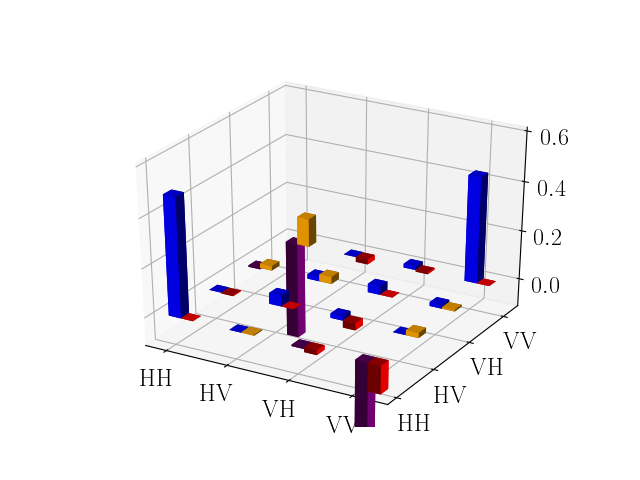

In [15]:
# with normalization
def likel_norm(ts_norm):
    ts = [1] + list(ts_norm)
    return likelihood(ns=ns,ts=ts)

ts_start = ts_from_rho(rho)
ts_opt_norm = op.fmin_bfgs(likel_norm, np.array(ts_start[1:])/ts_start[0],maxiter=10**6)
L_min = likel_norm(ts_opt_norm)
ts_opt_norm = [1] + list(ts_opt_norm)
print(ts_opt_norm)

rho_opt_norm = rho_from_T(ts_opt_norm)
fig,ax = plot_rho(rho_opt_norm)

name = 'tomo_ml_2'

# fig.savefig('report/img/%s.pgf' %name)
# fig.savefig('report/img/%s.png' %name)

Optimization terminated successfully.
         Current function value: 0.000193
         Iterations: 150
         Function evaluations: 3240
         Gradient evaluations: 180
[ 0.01428177 -0.04807553  0.2566446   0.91978198  0.10438675  0.80553417
 -0.01401605  0.28771784  0.03758554 -0.01419892 -0.0775557   0.06249614
 -0.00679286 -0.04938701  0.45857236  0.24653094]


<IPython.core.display.Javascript object>


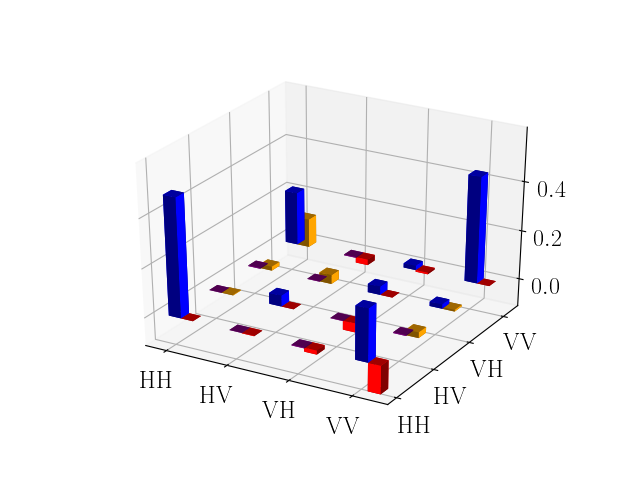

In [182]:
def likel(ts):
    return likelihood(ns=ns,ts=ts)

ts_opt_bfgs = op.fmin_bfgs(likel, ts_from_rho(rho),maxiter=10**6)
print(ts_opt_bfgs)

rho_opt = rho_from_T(ts_opt_bfgs)
fig,ax = plot_rho(rho_opt)

name = 'tomo_ml_2'

# fig.savefig('report/img/%s.pgf' %name)
# fig.savefig('report/img/%s.png' %name)

In [44]:
print(rho_opt_norm - rho_opt)

[[ 1.33073233e-04+0.00000000e+00j  3.07770321e-04-9.24132107e-06j
  -1.97789066e-04-6.99277883e-05j -1.93443850e-04-5.71252885e-05j]
 [ 3.07770321e-04+9.24132107e-06j -7.15029511e-05+0.00000000e+00j
   1.77240389e-04-1.46588601e-04j  8.68428669e-05+2.27211360e-04j]
 [-1.97789066e-04+6.99277883e-05j  1.77240389e-04+1.46588601e-04j
   7.83006423e-05+0.00000000e+00j -1.26211380e-04-1.73719607e-04j]
 [-1.93443850e-04+5.71252885e-05j  8.68428669e-05-2.27211360e-04j
  -1.26211380e-04+1.73719607e-04j -1.39870924e-04+0.00000000e+00j]]


In [19]:
# print rho without errors
for i in range(4):
    s = ''
    for j in range(4):
        s += '%.3f ' % np.real(rho_opt[i,j])
        if i != j:
            v = np.imag(rho_opt[i,j])
            if v >= 0:
                s += '+i%.3f' % v
            else:
                s += '-i%.3f' % -v
        if j == 3:
            if i != 3:
                s += ' \\\\'
        else:
            s += ' & '
    print(s)

0.484  & -0.001 -i0.002 & -0.003 -i0.016 & 0.217 -i0.117 \\
-0.001 +i0.002 & 0.045  & -0.002 -i0.037 & -0.003 +i0.023 \\
-0.003 +i0.016 & -0.002 +i0.037 & 0.035  & 0.018 +i0.007 \\
0.217 +i0.117 & -0.003 -i0.023 & 0.018 -i0.007 & 0.436 


In [64]:
# check for physicality
print(state)
print(r'$\sigma(\rho) = $', np.real(np.linalg.eigvals(rho_opt)))
print(r'Tr$\rho^2 = $', np.trace(rho_opt @ rho_opt))

decoherence
$\sigma(\rho) = $ [7.08960378e-01 2.14291501e-01 1.58326089e-07 7.67479620e-02]
Tr$\rho^2 = $ (0.5544359152118538+0j)


<IPython.core.display.Javascript object>


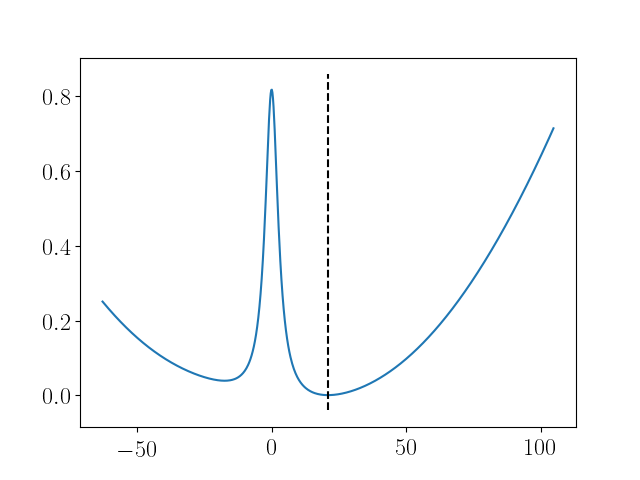

In [48]:
# plot likelihood
index = 2

fig,ax = plt.subplots()
t = ts_opt_norm[index]
t_min = t - 4*np.abs(t)
t_max = t + 4*np.abs(t)

t_i_s = np.linspace(t_min,t_max,800)

likess = []
ts_dummy = ts_opt_norm.copy()
for t_i in t_i_s:
    ts_dummy[index] = t_i
    likess.append(likel(ts_dummy))
    
likess = np.array(likess)
plt.plot(t_i_s,likess)
plt.plot([ts_opt_norm[index]]*2,ax.get_ylim(),color='black',linestyle='dashed')

<IPython.core.display.Javascript object>


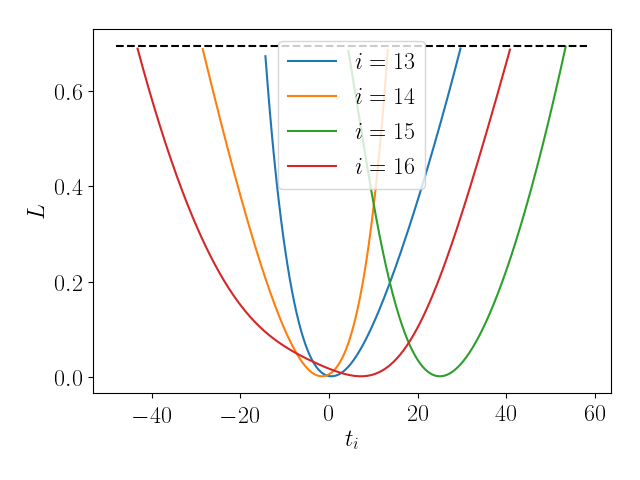

In [54]:
# plot likelihood
# index_list = [0,1,2,3]
# index_list = [4,5,6,7]
# index_list = [8,9,10,11]
# index_list = [12,13,14,15]
index_list = np.arange(1,4)
index_list = np.arange(4,8)
index_list = np.arange(8,12)
index_list = np.arange(12,16)
color_list = ['blue', 'orange', 'green', 'red', 'purple']

fig,ax = plt.subplots()

L_max = L_min + np.log(2)

for j,index in enumerate(index_list):
#     color = color_list[j]
    t = ts_opt_norm[index]
    t_min = t - 100
    t_max = t + 100

    t_i_s_aux = np.linspace(t_min,t_max,800)

    likess = []
    t_i_s = []
    ts_dummy = ts_opt_norm.copy()
    for t_i in t_i_s_aux:
        ts_dummy[index] = t_i
        l = likel(ts_dummy)
        if l < L_max:
            likess.append(l)
            t_i_s.append(t_i)

    likess = np.array(likess)
    t_i_s = np.array(t_i_s)
    plt.plot((t_i_s),likess, label='$i = %d$' %(index + 1))
#     plt.plot([t,t],ax.get_ylim(),color='black',linestyle='dashed')
plt.plot(ax.get_xlim(),[L_max]*2,color='black',linestyle='dashed')
plt.xlabel('$t_i$')
plt.ylabel('$L$')

plt.legend()
fig.tight_layout()

name = 'tomo_ml_1_t2-4'
name = 'tomo_ml_1_t5-8'
name = 'tomo_ml_1_t9-12'
name = 'tomo_ml_1_t13-16'

fig.savefig('report/img/%s.pgf' %name)
fig.savefig('report/img/%s.png' %name)

In [ ]:
# plot likelihood
index_list = [0,1,2,3]
index_list = [4,5,6,7]
index_list = [8,9,10,11]
index_list = [12,13,14,15]
index_list = np.arange(1,8)
color_list = ['blue', 'orange', 'green', 'red', 'purple']

fig,ax = plt.subplots()

for j,index in enumerate(index_list):
#     color = color_list[j]
    t = ts_opt_norm[index]
    t_min = t - 4*np.abs(t)
    t_max = t + 4*np.abs(t)

    t_i_s = np.linspace(t_min,t_max,800)

    likess = []
    ts_dummy = ts_opt_norm.copy()
    for t_i in t_i_s:
        ts_dummy[index] = t_i
        likess.append(likel(ts_dummy))

    likess = np.array(likess)
    plt.semilogy((t_i_s - t*np.ones_like(t_i_s))/t,likess, label='$i = %d$' %(index + 1))
plt.plot([0,0],ax.get_ylim(),color='black',linestyle='dashed')
plt.xlabel('$(t_i - t_i^{opt})/t_i^{opt})$')
plt.ylabel('$L$')

plt.legend()
fig.tight_layout()

#### Montecarlo walk

In [135]:
def MC_walk(start,maxiter,save_df,max_jump=1,min_jump=1):
    ts = list(start)
    L = likelihood(ns=ns,ts=ts)
    for j in tqdm(range(maxiter)):
        # choose a t
        i = np.random.choice(np.arange(1,16))
        #choose a jump
        jump = np.random.choice([-1,1])*np.random.uniform(max_jump,min_jump)
        #update and check
        ts[i] += jump
        new_L = likelihood(ns=ns,ts=ts)
        if new_L > L:
            r = np.random.uniform(0,1)
            if r > np.exp(L - new_L):
                # move rejected
                ts[i] -= jump
                new_L = L
        L = new_L
        
#         print(save_df)
        
        save_df.loc[len(save_df)] = [L] + ts
#         save_df.loc[len(save_df)] = list(np.arange(17))
        
    return

def rho_err(save_df,every=1,minstep=0):
    rhos = []
    for j in range(minstep,len(save_df)):
        if j % every == 0:
            rhos.append(rho_from_T(np.array(save_df.loc[j][1:])))
    
    rho_f = np.mean(rhos,axis=0)
    rho_err_real = np.std(np.real(rhos),axis=0)
    rho_err_imag = np.std(np.imag(rhos),axis=0)
    return rho_f,rho_err_real,rho_err_imag
    

In [124]:
save_df = pd.DataFrame(data=[],columns=['L']+['t%d' % i for i in range(1,17)])

In [141]:
MC_walk(start=ts_opt_norm,maxiter=100000,save_df=save_df,max_jump=2)

100%|██████████| 100000/100000 [18:15<00:00, 91.31it/s]


<IPython.core.display.Javascript object>


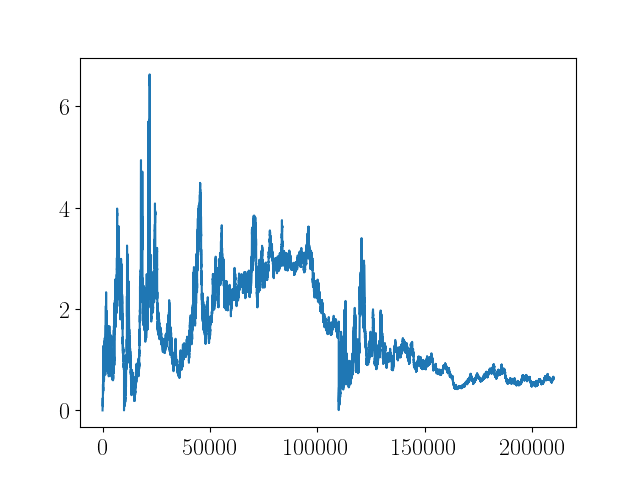

In [142]:
fig,ax = plt.subplots()
plt.plot(np.arange(len(save_df)),save_df['L'])

<IPython.core.display.Javascript object>


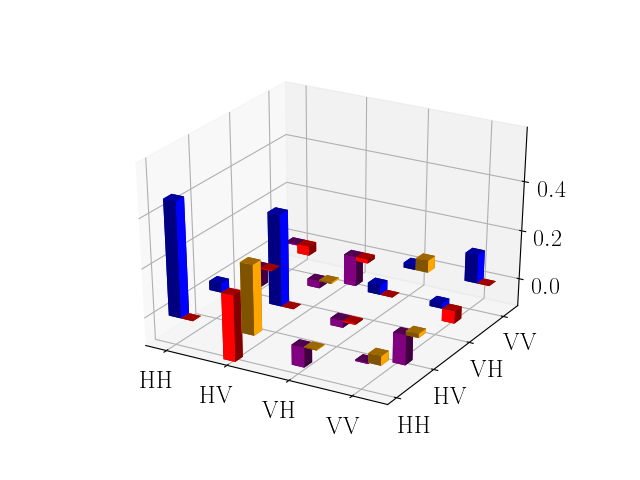

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fa9ea275910>)

In [154]:
plot_rho(rho_from_T(save_df.loc[50000][1:]))

<IPython.core.display.Javascript object>


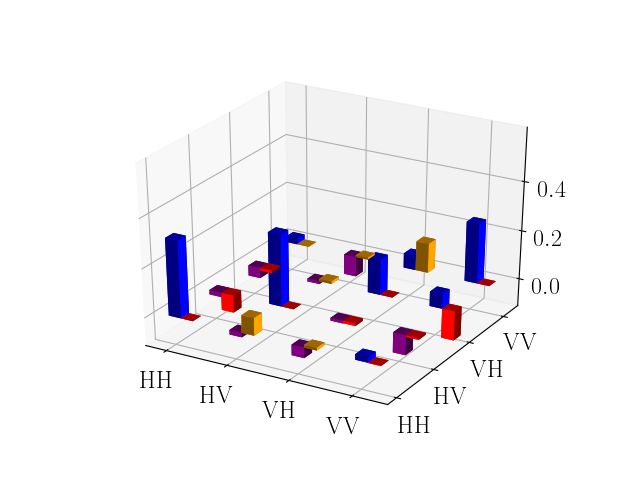

<IPython.core.display.Javascript object>


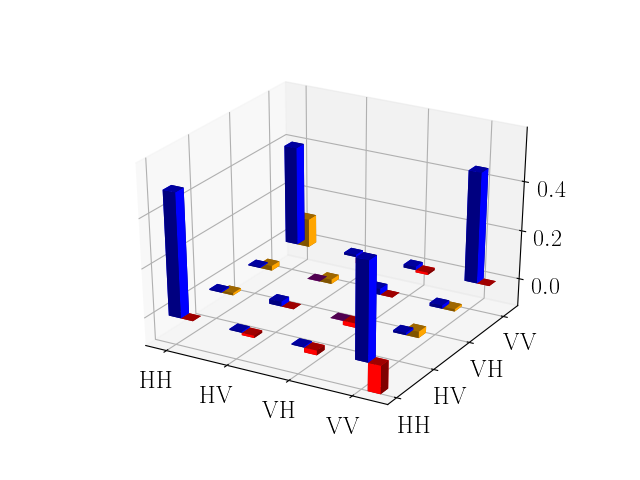

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fa9f1101290>)

In [143]:
rho_f,rho_err_real,rho_err_imag = rho_err(save_df,every=100,minstep=75000)
plot_rho(rho_f)
plot_rho(rho_opt_norm)

In [129]:
rho_err_real, rho_err_imag

(array([[0.1487016 , 0.05450162, 0.0625168 , 0.05425022],
        [0.05450162, 0.05897153, 0.04100739, 0.04624239],
        [0.0625168 , 0.04100739, 0.11627855, 0.03489199],
        [0.05425022, 0.04624239, 0.03489199, 0.07827493]]),
 array([[0.        , 0.05709972, 0.03589679, 0.02712383],
        [0.05709972, 0.        , 0.05511458, 0.05134842],
        [0.03589679, 0.05511458, 0.        , 0.0436997 ],
        [0.02712383, 0.05134842, 0.0436997 , 0.        ]]))

### Fidelity

In [16]:
psi_plus = np.sqrt(0.5)*(HH + VV)
psi_minus = np.sqrt(0.5)*(HH - VV)

def fidelity(rho,psi):
    return np.conj(psi) @ rho @ psi

def fidelity_m(rho_1,rho_2):
    s = sqrtm(rho_1)
    return np.trace(sqrtm(s @ rho_2 @ s))**2

def decoherence_state(p):
    return p*np.outer(psi_plus,psi_plus) + (1 - p)*np.diag([0.25,0.25,0.25,0.25])

def decoherence_minus_state(p):
    return p*np.outer(psi_minus,psi_minus) + (1 - p)*np.diag([0.25,0.25,0.25,0.25])

In [163]:
decoherence_state(0.3)

array([[0.325, 0.   , 0.   , 0.15 ],
       [0.   , 0.175, 0.   , 0.   ],
       [0.   , 0.   , 0.175, 0.   ],
       [0.15 , 0.   , 0.   , 0.325]])

In [176]:
fidelity_m(decoherence_state(1),decoherence_state(0.2))

0.4000000066640025

#### Actual computations


In [180]:
fidelity(rho_opt_norm,psi_minus)

(0.8720609323638479+0j)

0.8997995991983967 0.9428382315864084


<IPython.core.display.Javascript object>


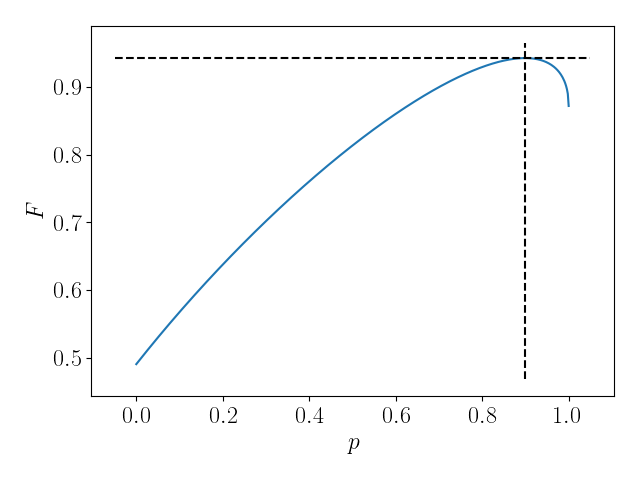

In [18]:
ps = np.linspace(0,1,500)
fs = np.zeros_like(ps)

for i,p in enumerate(ps):
#     rho_th = decoherence_state(p)
    rho_th = decoherence_minus_state(p)
    fs[i] = np.real(fidelity_m(rho_th,rho_opt_norm))
    
p_opt = ps[np.argmax(fs)]
f_opt = np.max(fs)
print(p_opt,f_opt)

fig,ax = plt.subplots()
plt.plot(ps,fs)
plt.plot([p_opt]*2, ax.get_ylim(), color='black',linestyle='dashed')
plt.plot(ax.get_xlim(),[f_opt]*2, color='black',linestyle='dashed')

plt.xlabel('$p$')
plt.ylabel('$F$')

fig.tight_layout()

name = 'psi_minus_fidelity'

fig.savefig('report/img/%s.pgf' %name)
fig.savefig('report/img/%s.png' %name)

<IPython.core.display.Javascript object>


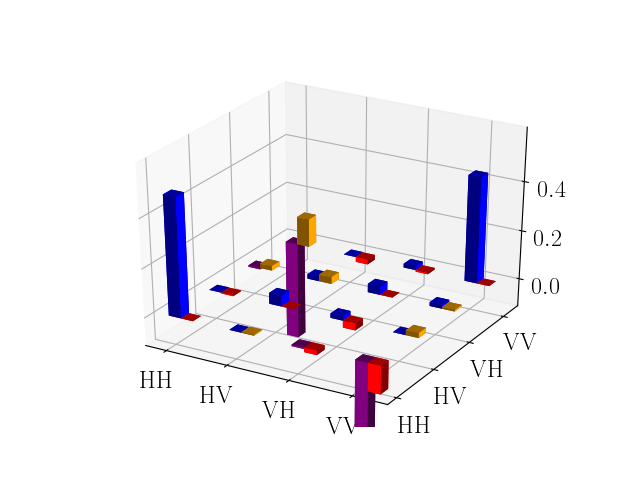

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fa9e9d33cd0>)

In [185]:
plot_rho(rho_opt_norm)